In [28]:
# We import all the libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import scipy as sp
import scipy

In [4]:
# We set a seed for debugging purposes
np.random.seed(4200)

In [5]:
def renorm_to_plot(Ag,t,Lap,tresh=0):
    rho= scipy.linalg.expm(-t*Lap)
    density=rho/(np.trace(rho))


    # Compute metagraph
    Gv = nx.Graph()
    Gv.add_nodes_from([i for i in range(len(Ag.nodes()))])
    for i in range(len(Ag.nodes())):
        for j in range(i+1,len(Ag.nodes)):

            if np.abs(rho[i,j]) >= min(np.abs(rho[i,i]),np.abs(rho[j,j]))-tresh:
                Gv.add_edge(i,j) 

        
        
    idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
    clusters = [idx_components[u] for u in Gv.nodes]

    clist = list(mcolors.CSS4_COLORS)*10
    np.random.shuffle(clist)

    colors = clusters.copy()
    for i in range(len(clusters)):
        colors[i] = clist[clusters[i]]

    G=nx.Graph()
    G.add_nodes_from([h for h in set(clusters)])
    for o in Ag.nodes():
        for p in Ag.nodes():
            if(Ag.has_edge(o,p) and clusters[o]!=clusters[p]):
                G.add_edge(clusters[o],clusters[p]) 

    
    new_l=list(set(list(zip(clusters,colors))))
    x={}
    for el in new_l:
        x[el[0]]=el[1]

    sing_col=[]
    for q in range(len(x)):
        sing_col.append(x[q])

    
    return G,colors,sing_col


In [6]:
def build_adjacency(length):

    # Now we want to create a couple of graphs. In practice, we start setting the number of nodes for each graph.


    # For each couple of nodes in a graph we generate a random natural number between 0 and 100.

    matrix = np.zeros((length, length))



    # We also want our graphs to be representative of reality (i.e. graphs are usually sparse).

    for i in range(length):
        for j in range(i):
            rnd = np.random.randint(1, 101)
            unif = np.random.rand()
            if unif > 0.6:
                matrix[i][j] = rnd
                matrix[j][i] = rnd
            else:
                matrix[i][j] = 0
                matrix[j][i] = 0


    return matrix

In [7]:
def build_measure(matrix, length):


    # Now we want to give a weight to each node in each matrix. In particulare if a node has a lot of connections, it should have a weight which is linear wrt the sum of its edges.

    M = []

    for i in range(length):
        s = sum(matrix[i,:])
        M.append(s)
    M = M/sum(M)

    
    return M
        

In [8]:

def build_similitude_matrices(matrix):    
    
    # This are matrices which represent the similitude between nodes.

    C = 1/(1 + matrix)

    return C

In [9]:
# Noise Maker
def make_noise(G, K):
    G2 = nx.Graph()
    G2.add_nodes_from(G.nodes()) 
    G2.add_edges_from(G.edges())
    l = len(G.nodes())
    surplus = int(l* 3/10)
    for i in range(surplus):
        G2.add_node(l+i)
        for a in range(int(l/4)):
            k = np.random.randint(0,l-1)
            w = np.random.randint(0,K)
            G2.add_edge(l+i,k,weight=w)

    return G2
    

In [10]:


def pseudofractal_d2(steps):
    edges = [(0,1),(1,2),(0,2)]
    n = 3
    for s in range(steps):
        boundary = edges.copy()
        for ed in boundary:
            edges.append((ed[0],n))
            edges.append((ed[1],n))
            n += 1

    G = nx.from_edgelist(edges)
    return G

def apollonian_d2(steps):
    edges = [(0,1),(1,2),(0,2)]
    new_boundary = edges.copy()
    n = 3
    for s in range(steps):
        boundary = new_boundary
        new_boundary = []
        for ed in boundary:
            edges.append((ed[0],n))
            edges.append((ed[1],n))
            new_boundary.append((ed[0],n))
            new_boundary.append((ed[1],n))
            n += 1

    G = nx.from_edgelist(edges)

    return G

In [11]:
# We set the possible hyperparameters.

hyper = {
    "d": 3,
    "beta": 0.5,
    "gamma": 0.5,
    "inner_n": 200,
    "outer_n": 30,
    "lambda_reg" : 0.001
}


In [51]:
def print_embeddings_one(embed_s, embed_t,lab=False):

    # Generiamo una matrice casuale 3x30
    matrix = embed_s

    # Creiamo un plot in 3D
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Estrarre le coordinate dei punti
    x = matrix[0, :]
    y = matrix[1, :]
    z = matrix[2, :]

    # Scatter plot dei punti
    ax.scatter(x, y, z, color='r',marker='o')
    
    # Aggiungi etichette con l'indice per ogni punto di embed_s
    if (lab):
        for i in range(embed_s.shape[1]):
            ax.text(x[i], y[i], z[i], f'{i}', color='red')

    x2=embed_t[0,:]
    y2 = embed_t[1,:]
    z2 = embed_t[2,:]
    ax.scatter(x2,y2,z2, color='b',marker='o')
    # Aggiungi etichette con l'indice per ogni punto di embed_s
    if (lab):
        for i in range(embed_t.shape[1]):
            ax.text(x2[i], y2[i], z2[i], f'{i}', color='b')


    # Etichette degli assi
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Titolo
    ax.set_title('Plot dei punti in R^3')

    plt.show()

In [13]:
def GWL_simple(C_s, C_t, M_s, M_t, hyper):
    """
    Simplified Gromov-Wasserstein Learning (GWL) with entropy-regularized cost, embedding updates,
    and regularization R(X_s, X_t).
    
    Parameters:
    - C_s: Cost matrix for source graph (length_s x length_s). 
    - C_t: Cost matrix for target graph (length_t x length_t).
    - M_s: Marginal distribution for source graph (length_s,).
    - M_t: Marginal distribution for target graph (length_t,).
    - beta: Regularization parameter for Sinkhorn iterations.
    - gamma: Regularization parameter for entropy term.
    - alpha: Weight for embedding-level cost regularization.
    - d: Dimension of the embeddings.
    - inner_n: Number of inner Sinkhorn iterations.
    - outer_n: Number of outer embedding updates.
    - lambda_reg: Regularization weight for R(X_s, X_t).
    """

    beta = hyper["beta"]
    gamma = hyper["gamma"]
    d = hyper["d"]
    inner_n = hyper["inner_n"]
    outer_n = hyper["outer_n"]
    lambda_reg = hyper["lambda_reg"]

    
    length_s, length_t = C_s.shape[0], C_t.shape[0]

    # Initialize embeddings
    embed_s = np.random.rand(d, length_s) * 5
    embed_t = np.random.rand(d, length_t) * 5

    # Initialize transport matrix
    T = np.outer(M_s, M_t)

    for m in range(outer_n):
        alpha_m = m / outer_n  # Gradual interpolation weight

        # Inner loop: Update transport matrix T using entropy regularization
        for n in range(inner_n):
            # Compute embedding-level cost
            K_embed = np.zeros((length_s, length_t))
            for i in range(length_s):
                for j in range(length_t):
                    # if L2
                    K_embed[i, j] = np.sum((embed_s[:, i] - embed_t[:, j]) ** 2)
                    # IF COSINE
                    # K_embed [i,j]= 1 - np.exp(-10*(1 - np.dot(embed_s[:, i], embed_t[:,j])/(np.linalg.norm(embed_s[:,i])*np.linalg.norm(embed_t[:,j]))))
                    # if Gaussian


            # Compute graph-level cost
            graph_cost = C_s @ T @ C_t.T
            C_mn = graph_cost + alpha_m * K_embed + gamma

            # Add entropy regularization term
            C_reg = C_mn - gamma * np.log(T + 1e-8)
            
            # Sinkhorn update
            kernel = np.exp(-C_reg / beta)
            a = np.ones(length_s)
            for _ in range(inner_n):
                b = M_t / (kernel.T @ a)
                a = M_s / (kernel @ b)

            T = np.diag(a) @ kernel @ np.diag(b)

        # Update embeddings by minimizing α_m <K(X_s, X_t), T> + β R(X_s, X_t)
        for _ in range(10):  # Gradient descent steps
            # Compute gradients of K(X_s, X_t)
            grad_s = np.zeros_like(embed_s)
            grad_t = np.zeros_like(embed_t)
            for i in range(length_s):
                for j in range(length_t):
                    grad_s[:, i] += 2 * T[i, j] * (embed_s[:, i] - embed_t[:, j])
                    grad_t[:, j] += 2 * T[i, j] * (embed_t[:, j] - embed_s[:, i])

            # Add gradients of R(X_s, X_t)
            for i in range(length_s):
                for j in range(length_s):
                    grad_s[:, i] += lambda_reg * 4 * ((np.sum((embed_s[:, i] - embed_s[:, j]) ** 2) - C_s[i, j]) *
                                                      (embed_s[:, i] - embed_s[:, j]))

            for i in range(length_t):
                for j in range(length_t):
                    grad_t[:, i] += lambda_reg * 4 * ((np.sum((embed_t[:, i] - embed_t[:, j]) ** 2) - C_t[i, j]) *
                                                      (embed_t[:, i] - embed_t[:, j]))

            # Gradient descent step
            embed_s -= alpha_m * grad_s
            embed_t -= alpha_m * grad_t

        # print_embeddings_one(embed_s, embed_t)

    # Compute final loss
    final_cost = np.sum(T * C_mn)
    entropy = -np.sum(T * np.log(T + 1e-8))
    total_loss = final_cost - gamma * entropy

    # Graph matching
    correspondence = np.zeros_like(T)
    for i in range(length_s):
        max_idx = np.argmax(T[i, :])
        correspondence[i, max_idx] = 1
    

    return embed_s, embed_t, T, correspondence, total_loss


# Prove

In [58]:
G_s= nx.barabasi_albert_graph(30, 1, seed = 43)
L_s=nx.laplacian_matrix(G_s).todense()
m_s=nx.adjacency_matrix(G_s).todense()

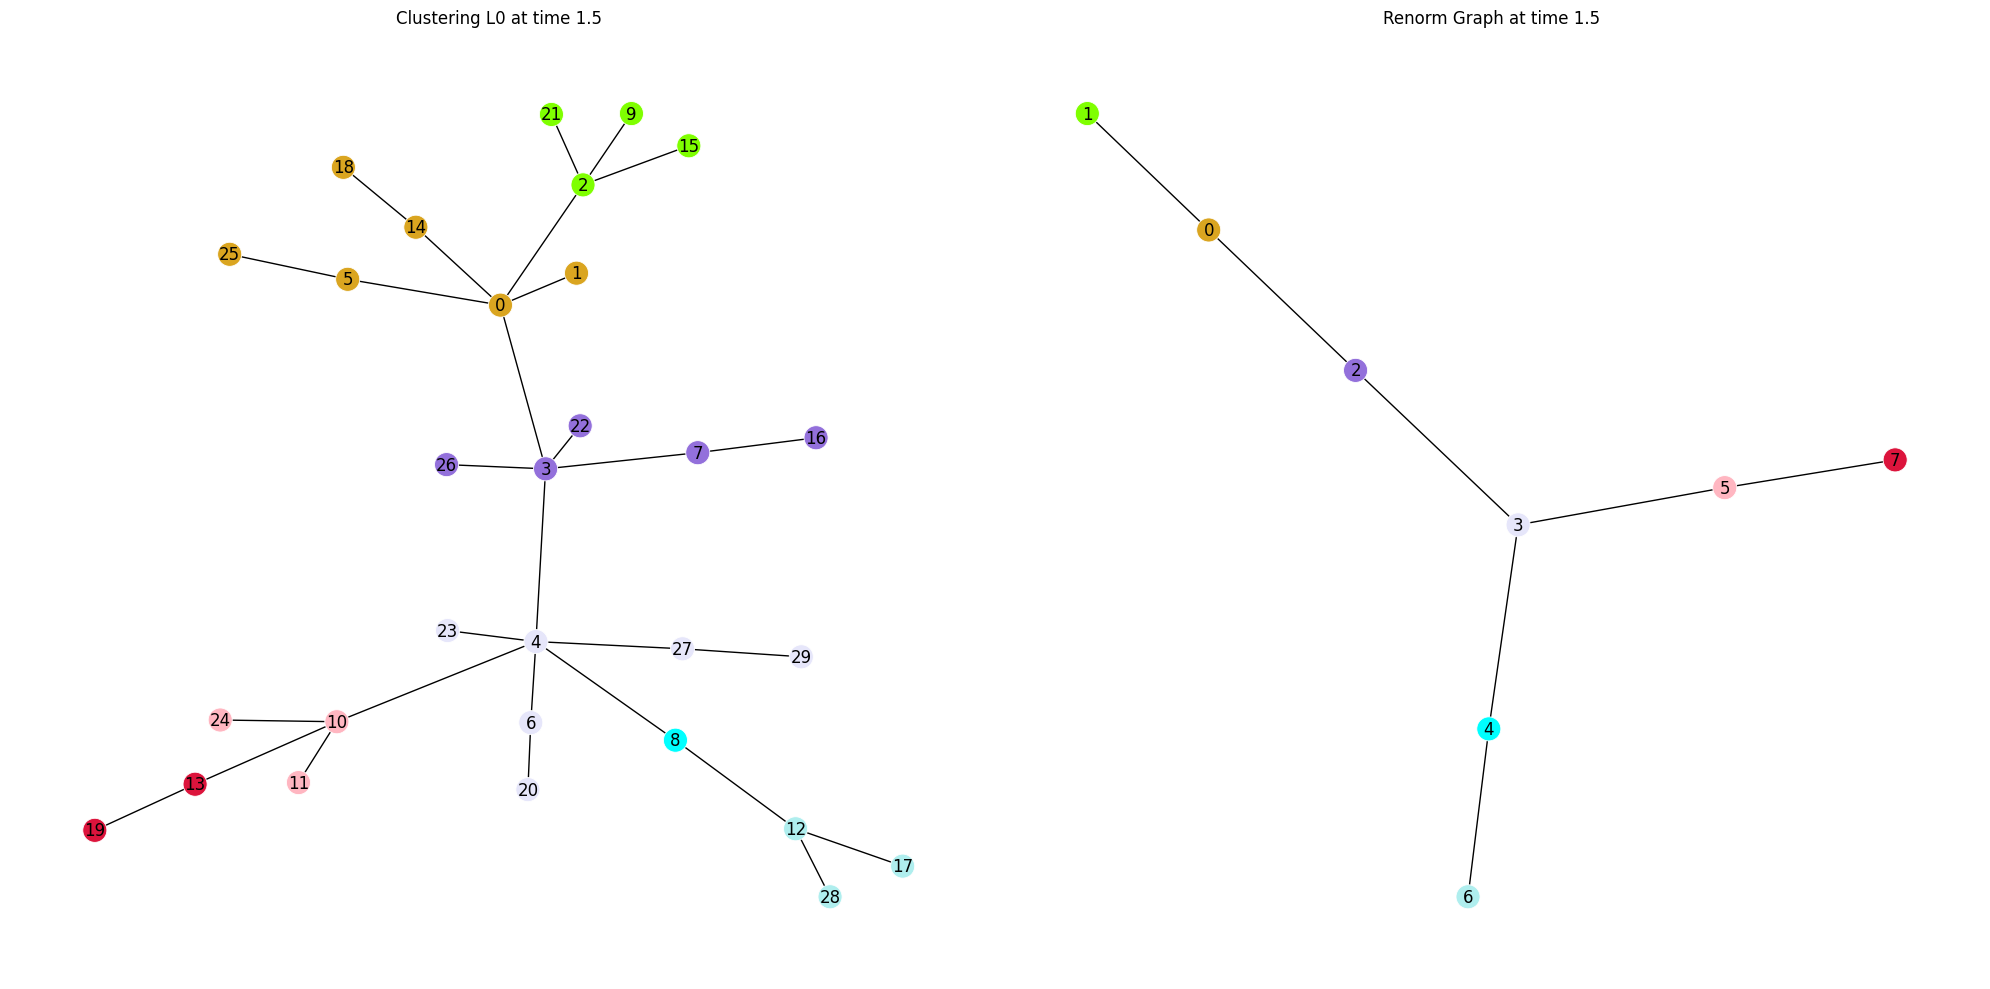

In [59]:
# Visualization

t=1.5

G_t,colors,sing_col=renorm_to_plot(G_s,t,L_s,tresh=0)
m_t=nx.adjacency_matrix(G_t).todense()

layout = nx.spring_layout(G_s, iterations=1000)

lay2=nx.spring_layout(G_t,iterations=70)

f,ax = plt.subplots(1,2,figsize = (20,10))
ax = ax.flatten()


nx.draw(G_s,ax=ax[0],pos=layout,node_color=colors,with_labels=True)
#nx.draw_networkx_labels(Ag,ax=ax[1],pos=layout,labels=labels_2)
ax[0].collections[1].set_alpha(1)
ax[0].collections[0].set_linewidth(0.6) 
ax[0].collections[0].set_edgecolor("#FFFFFF") 
ax[0].set_title(f"Clustering L0 at time {t}")



nx.draw(G_t,ax=ax[1],pos=lay2,node_color=sing_col,with_labels=True)
#nx.draw_networkx_labels(Ag,ax=ax[1],pos=layout,labels=labels_2)
#ax[1].collections[1].set_alpha(1)
ax[1].collections[0].set_linewidth(0.6) 
ax[1].collections[0].set_edgecolor("#FFFFFF") 
ax[1].set_title(f"Renorm Graph at time {t}")
plt.tight_layout()


In [63]:
l_s = len(G_s.nodes())
l_t = len(G_t.nodes())
M_s = build_measure(m_s, l_s)
M_t = build_measure(m_t, l_t)
C_s = build_similitude_matrices(m_s)
C_t = build_similitude_matrices(m_t)
embed_ba_s, embed_ba_t, T, correspondence, total_loss = GWL_simple(C_s, C_t, M_s, M_t, hyper)

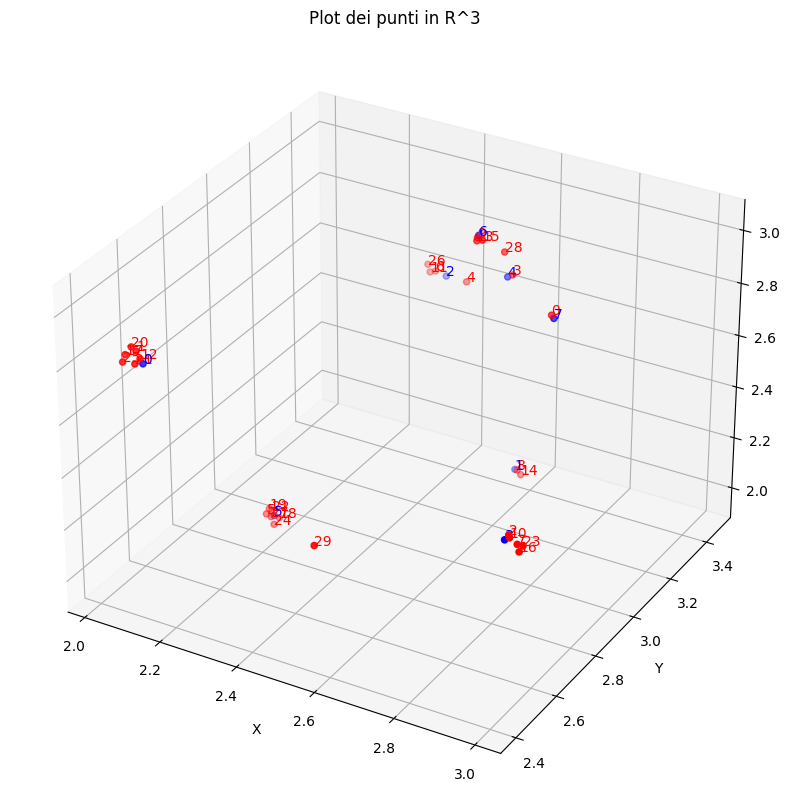

In [64]:
print_embeddings_one(embed_ba_s, embed_ba_t,lab=True)

In [65]:
correspondence

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 